### Set up software environment

In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
import numpy as np
from spectogram_script import load_all, epochs_as_rows
# from toolbox import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load index-to-frequency map, organized data. Extract from organized data all epoch rows.

In [3]:
freqs, dataDict = load_all()
epoch_idxs = (freqs > 5) & (freqs < 50)
freqs = freqs[epoch_idxs]
epochs = epochs_as_rows(dataDict)[
     : ,
    epoch_idxs
]

print(epochs.shape)
print(freqs.shape)
print(freqs)

(367629, 46)
(46,)
[ 5.859375   6.8359375  7.8125     8.7890625  9.765625  10.7421875
 11.71875   12.6953125 13.671875  14.6484375 15.625     16.6015625
 17.578125  18.5546875 19.53125   20.5078125 21.484375  22.4609375
 23.4375    24.4140625 25.390625  26.3671875 27.34375   28.3203125
 29.296875  30.2734375 31.25      32.2265625 33.203125  34.1796875
 35.15625   36.1328125 37.109375  38.0859375 39.0625    40.0390625
 41.015625  41.9921875 42.96875   43.9453125 44.921875  45.8984375
 46.875     47.8515625 48.828125  49.8046875]


# Expunging strange data.

In [4]:
alll = []
for session, channels in dataDict.items():
    for channel, vals in channels.items():
        if "gp_lfp" in channel:
            arr = vals[ : , epoch_idxs]
            alll.append((session, channel, arr.mean(), arr.std()))
for s, c, m, d in sorted(alll, key = lambda t: t[2]):
    print(f"{s} \t{c} \t{round(m, 2)}\t{round(d, 2)}")
print(np.array([t[2] for t in alll]).mean())
print(np.array([t[2] for t in alll]).std())

alll = []
for session, channels in dataDict.items():
    for channel, vals in channels.items():
        if "str_lfp" in channel:
            arr = vals[ : , epoch_idxs]
            alll.append((session, channel, arr.mean(), arr.std()))
for s, c, m, d in sorted(alll, key = lambda t: t[2]):
    print(f"{s} \t{c} \t{round(m, 2)}\t{round(d, 2)}")
print(np.array([t[2] for t in alll]).mean())
print(np.array([t[2] for t in alll]).std())

NPR-075.d07 	gp_lfp21 	11.28	8.38
NPR-075.d07 	gp_lfp2 	11.31	8.38
NPR-075.d07 	gp_lfp3 	11.33	8.26
NPR-075.d07 	gp_lfp22 	11.47	8.28
NPR-075.d07 	gp_lfp19 	11.53	8.25
NPR-075.d07 	gp_lfp23 	11.65	8.51
NPR-075.d07 	gp_lfp4 	11.66	8.4
NPR-075.d07 	gp_lfp17 	11.72	8.66
NPR-075.d07 	gp_lfp24 	11.95	8.56
NPR-075.d07 	gp_lfp5 	12.21	8.76
NPR-075.d07 	gp_lfp6 	12.28	8.76
NPR-075.d07 	gp_lfp8 	12.38	8.92
NPR040.c12 	gp_lfp19 	12.39	10.04
NPR-075.d07 	gp_lfp7 	12.52	8.92
NPR-075.d07 	gp_lfp9 	12.6	9.07
NPR064.c09 	gp_lfp19 	13.32	11.07
NPR-075.b13 	gp_lfp18 	13.72	11.51
NPR-075.b13 	gp_lfp17 	13.78	11.43
NPR-075.b13 	gp_lfp1 	13.79	11.44
NPR-075.b13 	gp_lfp2 	13.91	11.37
NPR-075.c013 	gp_lfp18 	14.01	10.57
NPR-075.c013 	gp_lfp20 	14.05	10.67
NPR-076.c09 	gp_lfp17 	14.13	10.43
NPR-075.b11 	gp_lfp18 	14.14	11.34
NPR-075.b11 	gp_lfp17 	14.15	11.26
NPR-073.d08 	gp_lfp2 	14.15	10.85
NPR-075.c013 	gp_lfp17 	14.2	10.56
NPR-076.c09 	gp_lfp2 	14.26	10.52
NPR-075.b13 	gp_lfp3 	14.28	11.67
NPR-075.c08 	g

# Expunging:
NPR065e.03   gp_lfp19 	32.04	37.82

NPR-073.d04  gp_lfp1 	37.46	45.47

NPR040.c12   gp_lfp1 	39.48	41.0

NPR-073.d08  gp_lfp1 	40.94	49.64

NPR040.c12   gp_lfp18 	43.05	48.58

pjx289e08    gp_lfp5 	46.98	65.33

NPR-073.d08  gp_lfp18 	72.02	85.26

In [4]:
BANNED = [
    ("NPR065e.03", "gp_lfp19"),
    ("NPR-073.d04", "gp_lfp1"),
    ("NPR040.c12", "gp_lfp1"),
    ("NPR-073.d08", "gp_lfp1"),
    ("NPR040.c12", "gp_lfp18"),
    ("pjx289e08", "gp_lfp5"),
    ("NPR-073.d08", "gp_lfp18")
]

epochs = []
for session, channels in dataDict.items():
    for channel, values in channels.items():
        if (session, channel) in BANNED:
            continue
        else:
            epochs.append(values)

epochs = np.concatenate(epochs, axis = 0)[ : , epoch_idxs]
print(epochs.shape)

(362184, 46)


### Find principal components. Consider explained variance.

In [5]:
n_components = 8
n_features = epochs.shape[1]
pca_model = PCA(n_components = n_components).fit(epochs.copy())

for i in range(0, n_components):
    print(f"Component {i} explains\t{round(100 * pca_model.explained_variance_ratio_[i], 2)}%\tvariance.\
        \tCumulative sum = {round(100 * pca_model.explained_variance_ratio_[ : i + 1].sum(), 2)}%")
    
        

Component 0 explains	33.55%	variance.        	Cumulative sum = 33.55%
Component 1 explains	17.38%	variance.        	Cumulative sum = 50.92%
Component 2 explains	11.72%	variance.        	Cumulative sum = 62.64%
Component 3 explains	9.22%	variance.        	Cumulative sum = 71.86%
Component 4 explains	6.62%	variance.        	Cumulative sum = 78.49%
Component 5 explains	4.81%	variance.        	Cumulative sum = 83.3%
Component 6 explains	4.16%	variance.        	Cumulative sum = 87.46%
Component 7 explains	3.08%	variance.        	Cumulative sum = 90.54%


### Explained variance is high. Find representation of epoch rows in Principal Component subspace.

In [6]:
all_pcs = pca_model.transform(epochs.copy())
print(all_pcs.shape)

(362184, 8)


In [6]:
# ed1 = np.arange(-100,250,10)
# hh1,edx = np.histogram(all_pcs[:,0],ed1)

# ed2 = np.arange(-100,200,10)
# hh2,edx = np.histogram(all_pcs[:,1],ed2)



# plt.subplot(2,2,1)
# plt.plot(hh2,ed2[0:-1])

# plt.subplot(2,2,2)
# plt.plot(all_pcs[ : , 0], all_pcs[ : , 1], ".", ms = 1, alpha = 0.5)
# plt.xlim((-100,250))
# plt.ylim((-100,100))
# plt.subplot(2,2,4)
# plt.plot(ed1[0:-1],hh1)

# plt.show()

### Crosscorrelation is zero for all PC pairs. Consider distributions of each PC independent from each other PC.

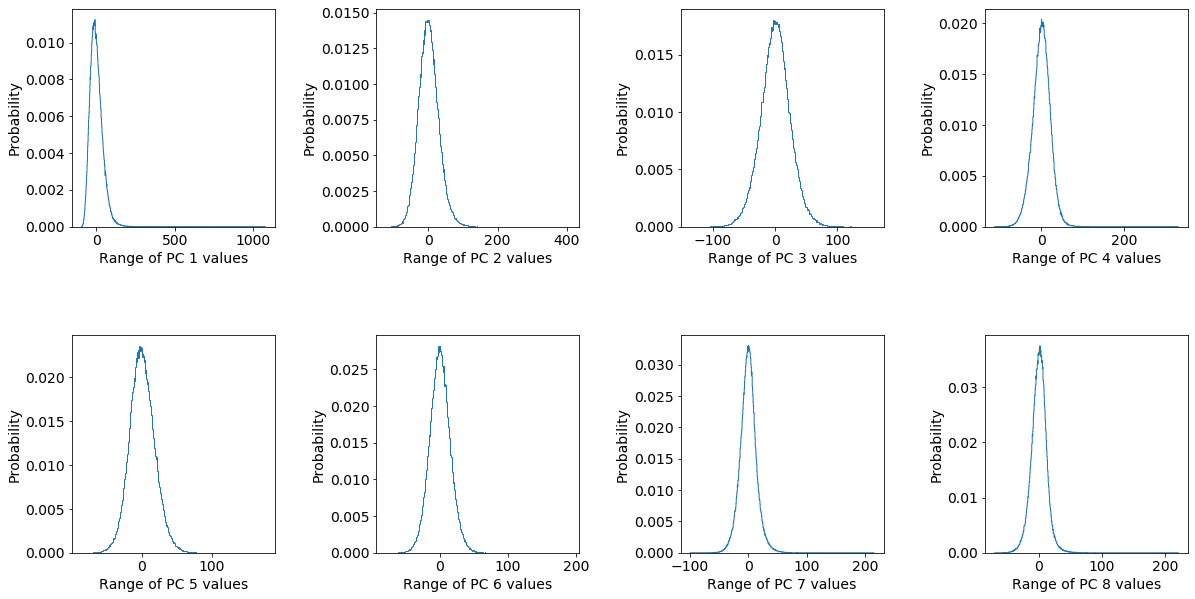

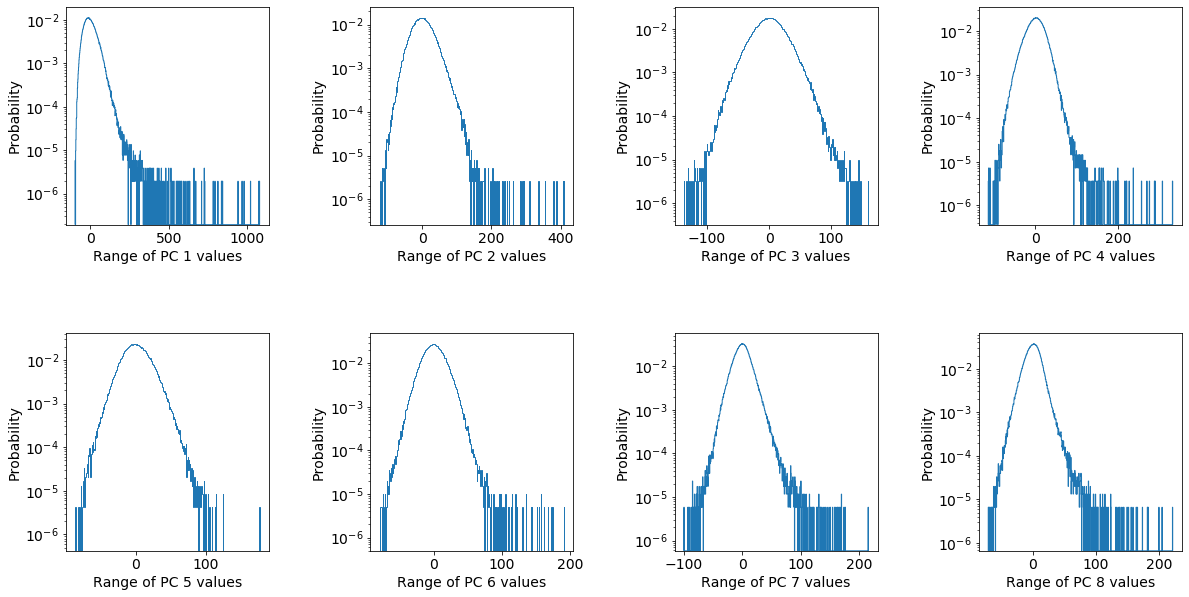

In [30]:
# pdfs = []
# pdfslg2 = []

# for idx in range(n_components):
#     xs, ys, yslg2 = aprx_pdf_1d(all_pcs[ : , idx])
#     pdfs.append((xs, ys))
#     pdfslg2.append((xs, yslg2))
    
figsize = (20, 10)
plt.rcParams.update({'font.size': 14})
    
plt.figure(figsize = figsize)
for idx in range(n_components):
    plt.subplot(2, 4, idx + 1)
    plt.xlabel(f"Range of PC {idx + 1} values")
    plt.ylabel("Probability")
#     plt.title(f"Approximation of PDF of PC {idx}")
    plt.hist(
        all_pcs[ : , idx],
        bins = 'auto',
        histtype = 'step',
        density = True
    )
    
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.savefig("../_data/production/PCA-adjusted/PCA5.pdfsKex.png")
plt.show()
    
plt.figure(figsize = figsize)
for idx in range(n_components):
    plt.subplot(2, 4, idx + 1)
    plt.xlabel(f"Range of PC {idx + 1} values")
    plt.ylabel("Probability")
#     plt.title(f"Approximation of PDF of PC {idx}")
    plt.hist(
        all_pcs[ : , idx],
        bins = 'auto',
        histtype = 'step',
        density = True,
        log = True
    )
    
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.savefig("../_data/production/PCA-adjusted/PCA5.pdfsKexlg2.png")
plt.show()

### Consider individual PCs.

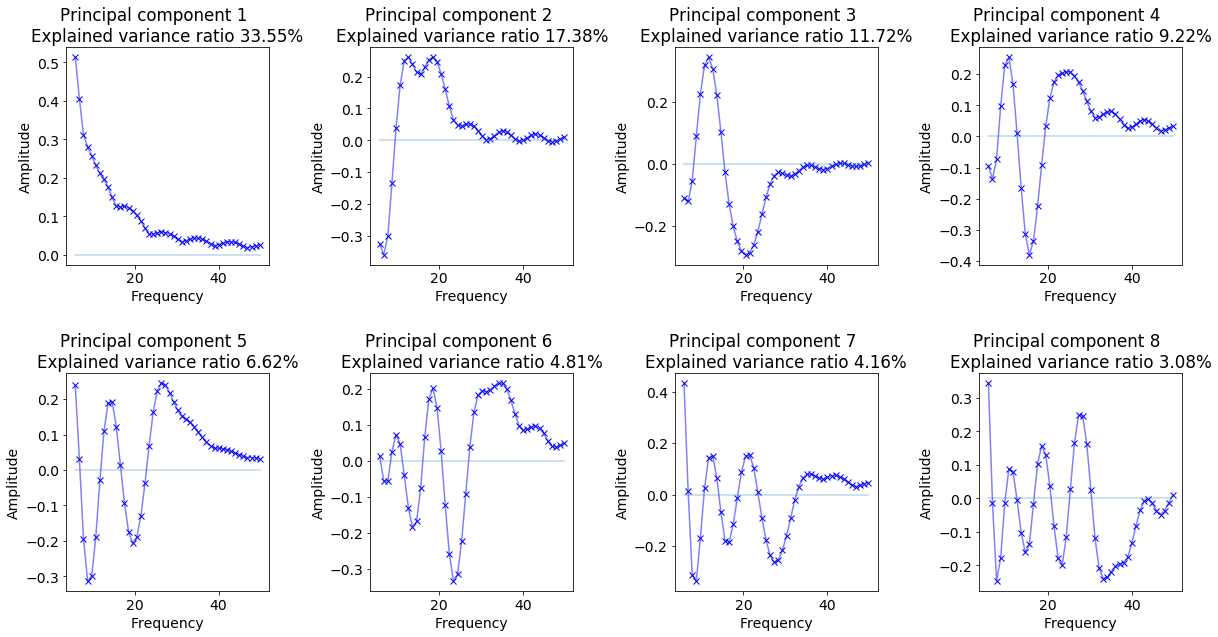

In [27]:
plt.figure(figsize = (20, 10))
plt.rcParams.update({'font.size': 14})
for idx in range(0, n_components):
    plt.subplot(2, 4, idx + 1)
    plt.plot(freqs, pca_model.components_[idx], 'bx')
    plt.plot(freqs, pca_model.components_[idx], 'b', alpha = 0.5)
    plt.plot([np.min(freqs), np.max(freqs)], [0, 0], alpha = 0.3)
    plt.title(f"Principal component {idx + 1} \
    \nExplained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.savefig("../_data/production/PCA-adjusted/PCA5.PCs.png")
plt.show()

### Consider STR and GP channels.

In [31]:
pcs_str = []
pcs_gp  = []
for session, channels in dataDict.items():
    for channel, vals in channels.items():
        if (session, channel) in BANNED:
            continue
        
        if "str_lfp" in channel:
            pcs_str.append(vals[ : , epoch_idxs])
        if "gp_lfp" in channel:
            pcs_gp. append(vals[ : , epoch_idxs])
pcs_str = pca_model.transform(np.concatenate(pcs_str, axis = 0))
pcs_gp  = pca_model.transform(np.concatenate(pcs_gp , axis = 0))

print(pcs_str.shape)
print(pcs_gp.shape)

(131208, 8)
(230976, 8)


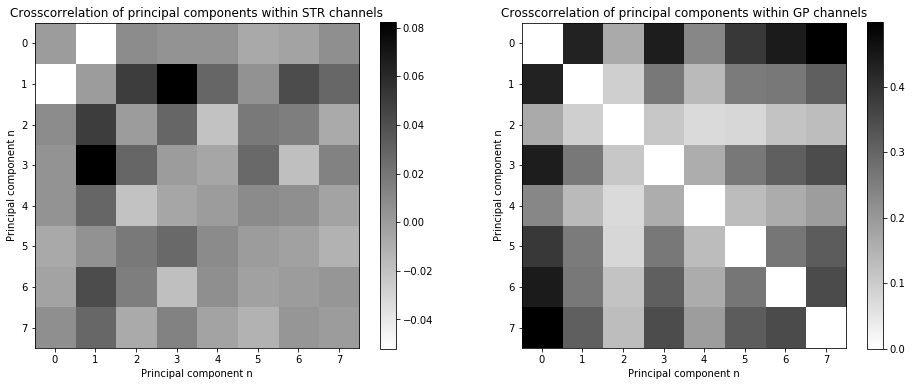

In [30]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.imshow(
    np.corrcoef(pcs_str.transpose()) - np.identity(n_components), 
    cmap = 'gist_yarg'
)
plt.xlabel("Principal component n")
plt.ylabel("Principal component n")
plt.title("Crosscorrelation of principal components within STR channels")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(
    np.corrcoef(pcs_gp.transpose()) - np.identity(n_components), 
    cmap = 'gist_yarg'
)
plt.xlabel("Principal component n")
plt.ylabel("Principal component n")
plt.title("Crosscorrelation of principal components within GP channels")
plt.colorbar()

plt.show()

# ----------------------GP--------------------- #
[[ 1.00000000e+00  3.80381197e-02 -7.23023892e-03 -4.64235025e-03
  -5.79082607e-03  1.07315460e-03  2.51180084e-03 -2.71542741e-03]
 [ 3.80381197e-02  1.00000000e+00 -2.13254391e-02 -4.00308928e-02
  -9.76111596e-03  2.91257364e-03 -2.41126356e-02 -1.97621621e-02]
 [-7.23023892e-03 -2.13254391e-02  1.00000000e+00 -1.63482837e-02
   8.69389091e-03 -1.19636628e-02 -8.46957108e-03  5.09257020e-03]
 [-4.64235025e-03 -4.00308928e-02 -1.63482837e-02  1.00000000e+00
   8.88246963e-04 -1.67981226e-02  1.06099317e-02 -6.78265711e-03]
 [-5.79082607e-03 -9.76111596e-03  8.69389091e-03  8.88246963e-04
   1.00000000e+00 -7.77868270e-03 -4.12296589e-03  3.62017487e-03]
 [ 1.07315460e-03  2.91257364e-03 -1.19636628e-02 -1.67981226e-02
  -7.77868270e-03  1.00000000e+00  1.62030897e-03  8.32788210e-03]
 [ 2.51180084e-03 -2.41126356e-02 -8.46957108e-03  1.06099317e-02
  -4.12296589e-03  1.62030897e-03  1.00000000e+00 -1.95509696e-03]
 [-2.71542741e-03 -

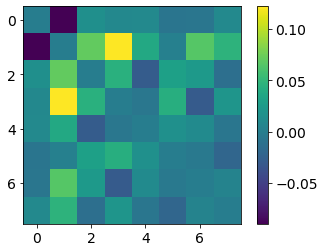

In [35]:
print("# ----------------------GP--------------------- #")
print(np.corrcoef(pcs_gp.transpose()))
print("# ----------------------STR-------------------- #")
print(np.corrcoef(pcs_str.transpose()))

gp_cc = np.corrcoef(pcs_gp.transpose())
for row in gp_cc:
    strn = ""
    for n in row:
       strn += f"{round(n, 2)} & "
    print(strn)
    
print()
str_cc = np.corrcoef(pcs_str.transpose())
for row in str_cc:
    strn = ""
    for n in row:
       strn += f"{round(n, 2)} & "
    print(strn)
    
print("#######")
plt.imshow(str_cc-gp_cc)
plt.colorbar()
plt.show()

### Crosscorrelations notably higher. Still plot approximate PDFs.

<Figure size 2592x2160 with 0 Axes>

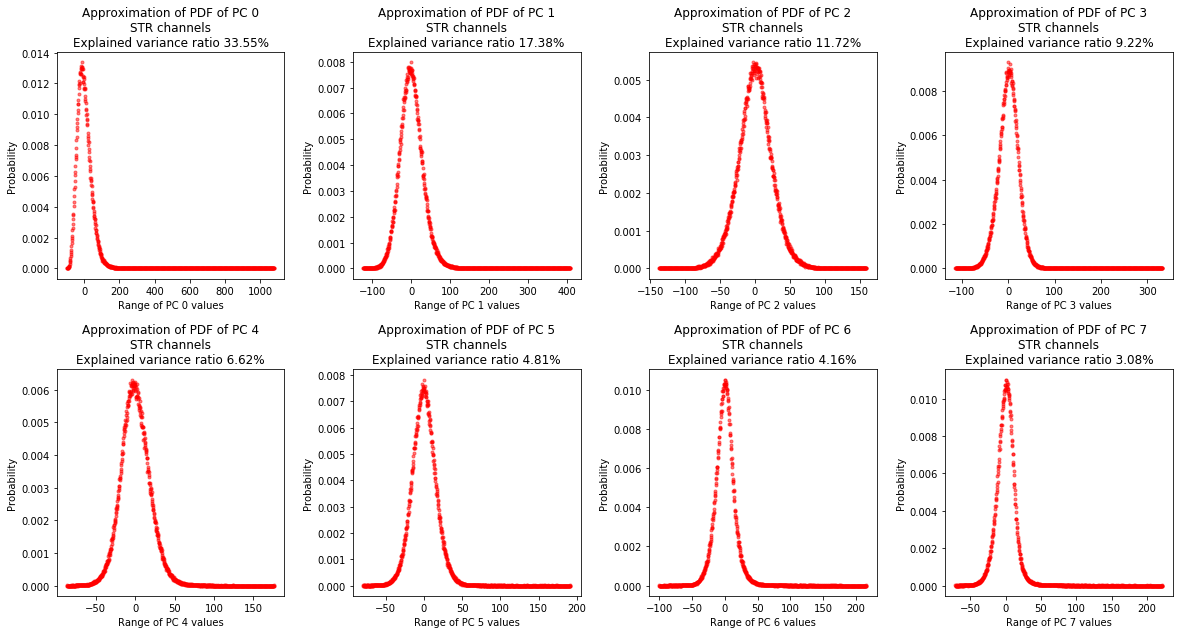

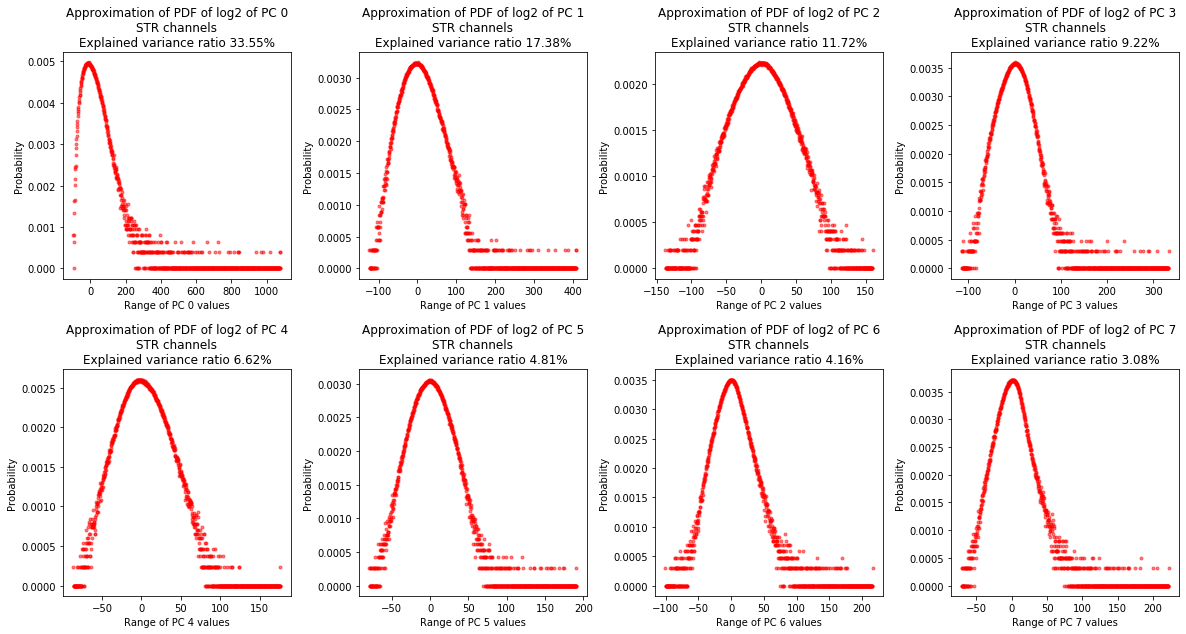

<Figure size 2592x2160 with 0 Axes>

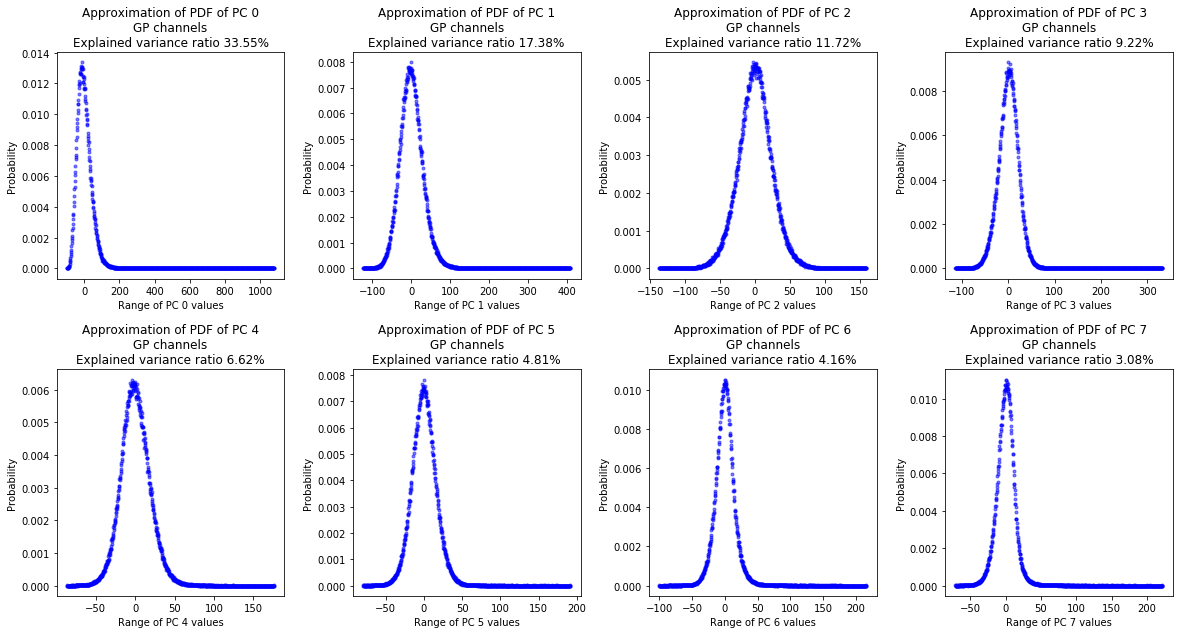

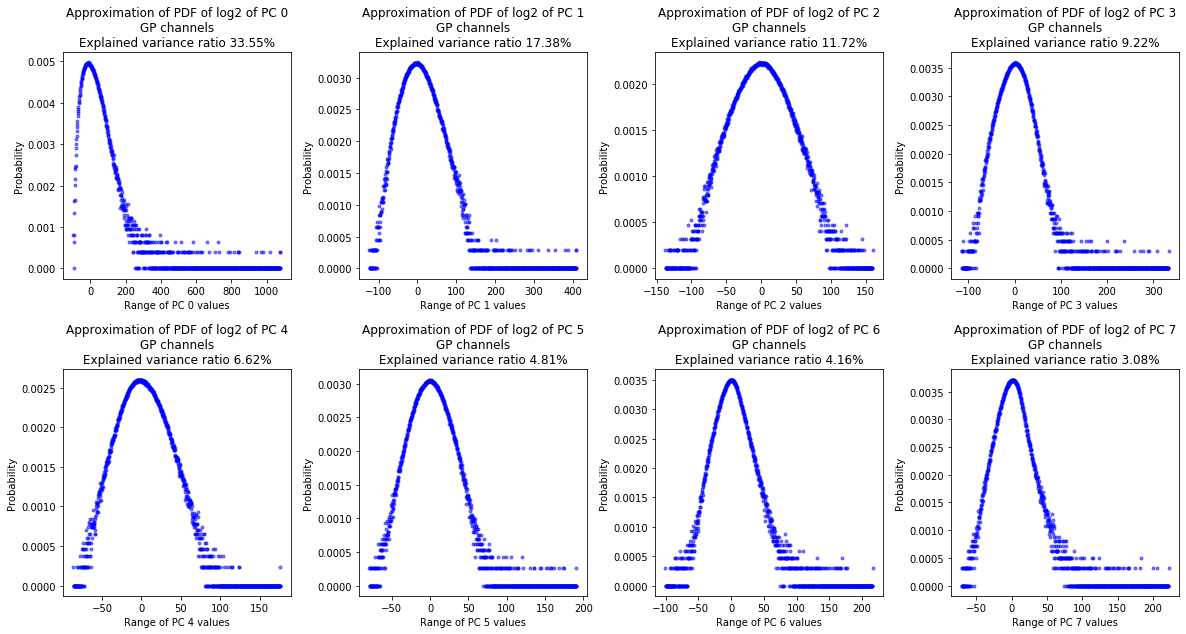

In [28]:
for channel, pcs, col in zip(["STR", "GP"], [pcs_str, pcs_gp], ['r', 'b']):
    plt.figure(figsize = (36, 30))
    for idx, (pos1, pos2) in zip(
        range(0, n_components),
        [(1, 5), (2, 6), (3, 7), (4, 8),
         (9, 13), (10, 14), (11, 15), (12, 16)]
    ):
        xs, ys, yslg2 = aprx_pdf_1d(pcs[ : , idx])
    
    pdfs = []
    pdfslg2 = []

    for idx in range(n_components):
        xs, ys, yslg2 = aprx_pdf_1d(all_pcs[ : , idx])
        pdfs.append((xs, ys))
        pdfslg2.append((xs, yslg2))

    figsize = (20, 10)

    plt.figure(figsize = figsize)
    for idx, (xs, ys) in enumerate(pdfs):
        plt.subplot(2, 4, idx + 1)
        plt.xlabel(f"Range of PC {idx} values")
        plt.ylabel("Probability")
        plt.title(
            f"Approximation of PDF of PC {idx}\n" + \
            f"{channel} channels\n" + 
            f"Explained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%"     
        )
        plt.plot(xs, ys, col + '.', alpha = 0.5)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
    plt.savefig(f"../_data/PCA/PCA5.pdfsKex.{channel}.png")
    plt.show()
    plt.close()

    plt.figure(figsize = figsize)
    for idx, (xs, ys) in enumerate(pdfslg2):
        plt.subplot(2, 4, idx + 1)
        plt.xlabel(f"Range of PC {idx} values")
        plt.ylabel("Probability")
        plt.title(
            f"Approximation of PDF of log2 of PC {idx}\n" + \
            f"{channel} channels\n" +  
            f"Explained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%"    
        )
        plt.plot(xs, ys, col + '.', alpha = 0.5)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
    plt.savefig(f"../_data/PCA/PCA5.pdfsKexlg2.{channel}.png")
    plt.show()
    plt.close()

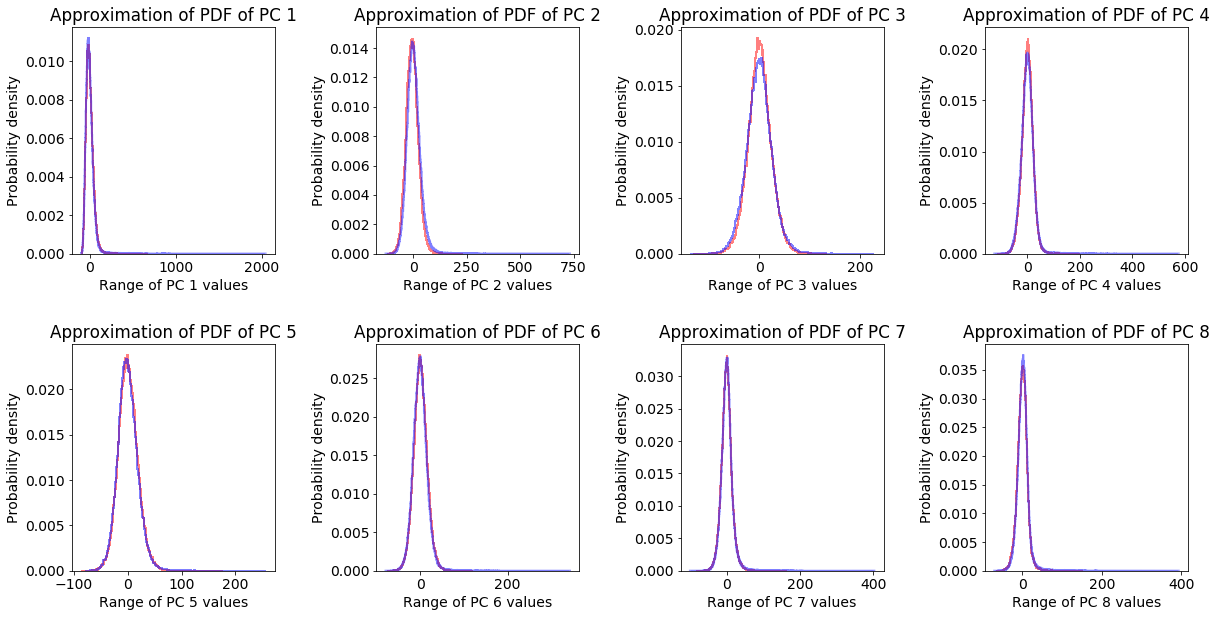

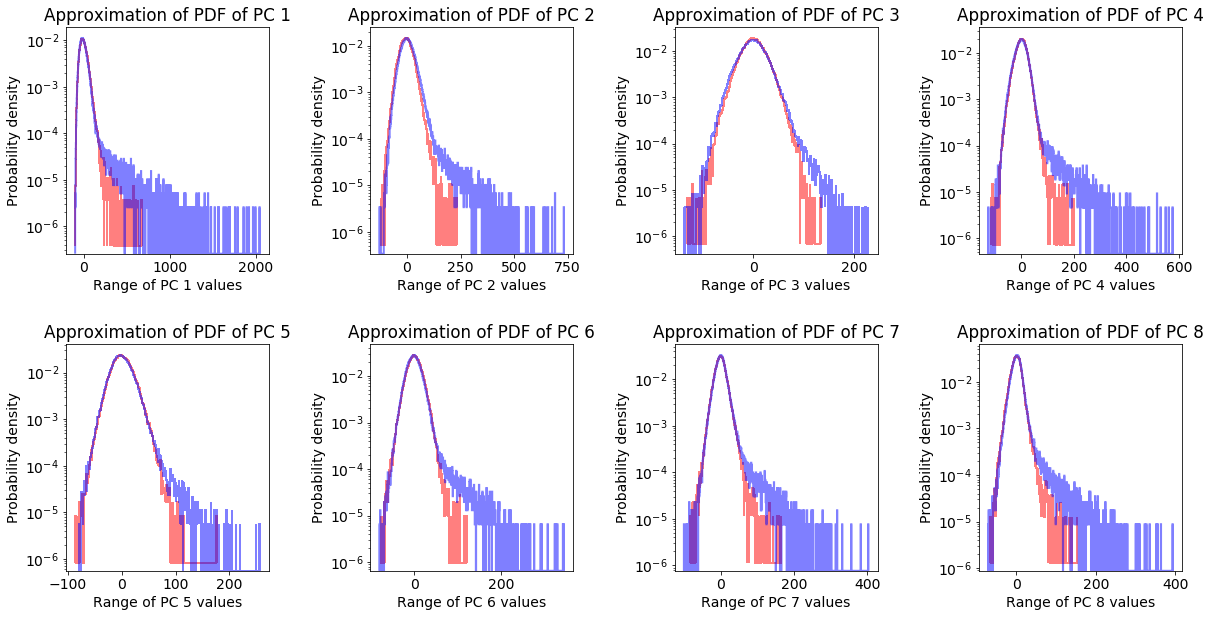

In [25]:
plt.figure(figsize = (20, 10))
for idx in range(n_components):

    plt.subplot(2, 4, idx + 1)
    plt.xlabel(f"Range of PC {idx + 1} values")
    plt.ylabel(f"Probability density")
    plt.title(f"Approximation of PDF of PC {idx + 1}")
    plt.hist(
        pcs_str[ : , idx],
        bins = 'auto',
        histtype = 'step',
        density = True,
        color = 'red',
        alpha = 0.5,
        lw = 2.
    )
    plt.hist(
        pcs_gp[ : , idx],
        bins = 'auto',
        histtype = 'step',
        density = True,
        color = 'blue',
        alpha = 0.5,
        lw = 2.
    )

plt.subplots_adjust(wspace = 0.5, hspace = 0.4)
plt.savefig(f"../_data/production/PCA-adjusted/PCA5.kex.both.png")
plt.show()
plt.close()

plt.figure(figsize = (20, 10))
plt.rcParams.update({'font.size': 14})
for idx in range(n_components):
    
    plt.subplot(2, 4, idx + 1)
    plt.xlabel(f"Range of PC {idx + 1} values")
    plt.ylabel(f"Probability density")
    plt.title(f"Approximation of PDF of PC {idx + 1}")
    plt.hist(
        pcs_str[ : , idx],
        bins = 'auto',
        histtype = 'step',
        density = True,
        color = 'red',
        log = True,
        alpha = 0.5,
        lw = 2.
    )
    plt.hist(
        pcs_gp[ : , idx],
        bins = 'auto',
        histtype = 'step',
        density = True,
        color = 'blue',
        log = True,
        alpha = 0.5,
        lw = 2.
    )

plt.subplots_adjust(wspace = 0.5, hspace = 0.4)
plt.savefig(f"../_data/production/PCA-adjusted/PCA5.kex.bothlg2.png")
plt.show()
plt.close()

### Animals.

In [22]:
sessions = [
    'NPR-076.c09',
    'NPR064.c09',
    'NPR065e.03'
]
for a in sessions:
    for channels, _ in dataDict[a].items():
        print(channels)
    print()

gp_lfp26
gp_lfp7
gp_lfp21
gp_lfp9
str_lfp15
gp_lfp23
str_lfp16
gp_lfp25
gp_lfp2
gp_lfp5
gp_lfp3
gp_lfp6
gp_lfp4
gp_lfp8
gp_lfp10
gp_lfp18
gp_lfp22
str_lfp14
str_lfp13
gp_lfp17
gp_lfp20
gp_lfp24
gp_lfp11
gp_lfp1

str_lfp30
gp_lfp7
gp_lfp21
gp_lfp9
str_lfp29
str_lfp15
gp_lfp23
str_lfp16
gp_lfp2
gp_lfp5
gp_lfp3
str_lfp31
gp_lfp6
str_lfp27
gp_lfp4
gp_lfp8
str_lfp12
gp_lfp19
gp_lfp18
gp_lfp22
str_lfp14
str_lfp13
str_lfp32
gp_lfp17
str_lfp28
gp_lfp20
gp_lfp1

str_lfp30
gp_lfp7
gp_lfp21
gp_lfp9
str_lfp29
str_lfp15
gp_lfp23
str_lfp16
str_lfp11
gp_lfp25
gp_lfp2
gp_lfp5
gp_lfp3
str_lfp31
gp_lfp6
str_lfp27
gp_lfp4
gp_lfp8
str_lfp12
gp_lfp19
gp_lfp18
gp_lfp22
str_lfp14
str_lfp13
str_lfp32
gp_lfp17
str_lfp28
gp_lfp20
gp_lfp24
gp_lfp1



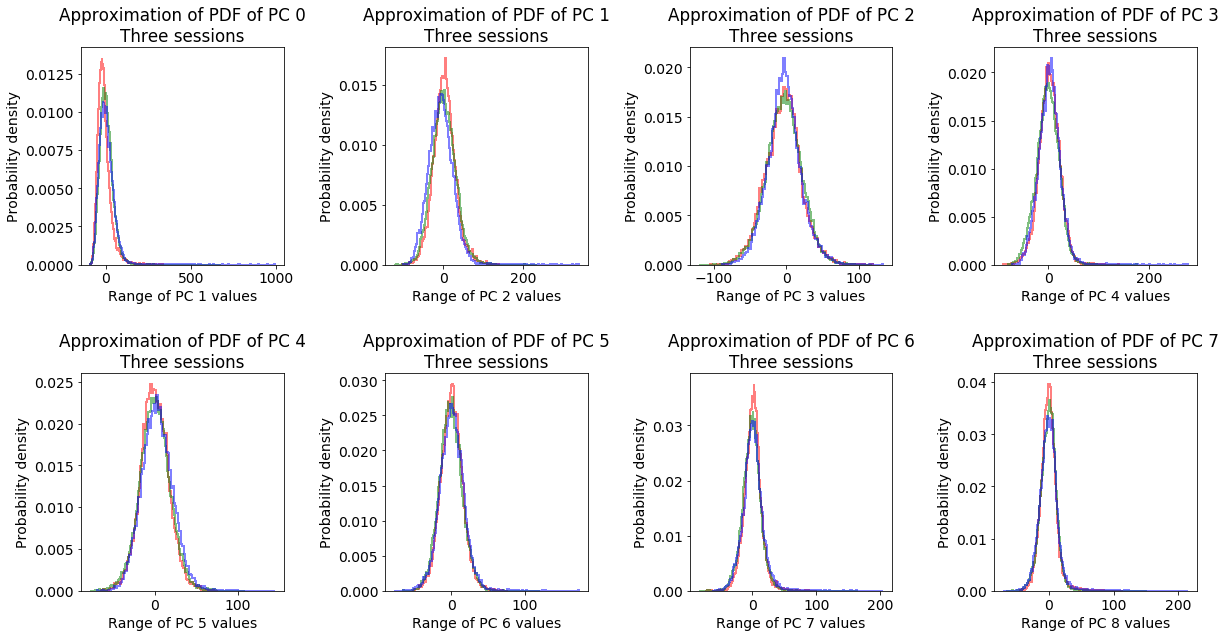

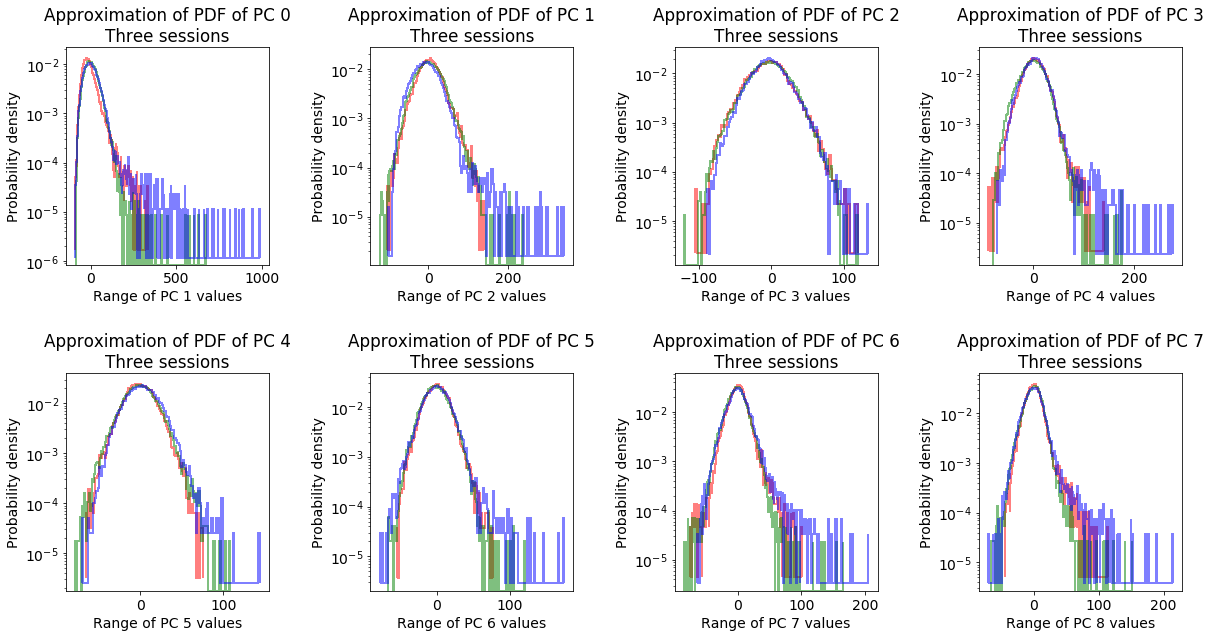

In [26]:
sessions = [
    'NPR-076.c09',
    'NPR064.c09',
    'NPR065e.03'
]

sessData = {
    a: np.concatenate([
        [
            v for _, v in dataDict[a].items()
        ]
    ], axis = 0)
        [ : , : , epoch_idxs]
        .reshape((-1, 46))
    for a in sessions
}

for type_fig in ["normal", "lg"]:
    
    plt.figure(figsize = (20, 10))
    
    for idx in range(n_components):
        plt.subplot(2, 4, idx + 1)
        
        plt.xlabel(f"Range of PC {idx + 1} values")
        plt.ylabel(f"Probability density")
        plt.title(f"Approximation of PDF of PC {idx}" + \
        f"\nThree sessions")
        
        for (sess, data), col in zip(sessData.items(), ['r', 'g', 'b']):
            if type_fig == "normal":
                
                plt.hist(
                    pca_model.transform(data.copy())[ : , idx],
                    bins = 'auto',
                    histtype = 'step',
                    density = True,
                    color = col,
                    alpha = 0.5,
                    lw = 2.
                )
                
            elif type_fig == "lg":
                
                plt.hist(
                    pca_model.transform(data.copy())[ : , idx],
                    bins = 'auto',
                    histtype = 'step',
                    density = True,
                    color = col,
                    log = True,
                    alpha = 0.5,
                    lw = 2.
                )
                
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
    plt.savefig(f"../_data/production/PCA-adjusted/PCAAnimals{type_fig}.png")
    plt.show()
    plt.close()

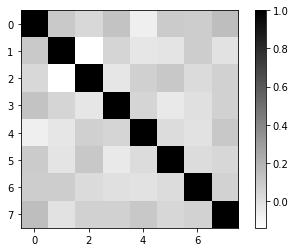

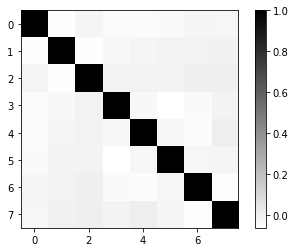

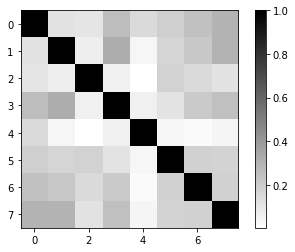

In [17]:
for k,v in sessData.items():
    plt.imshow(
        np.corrcoef(
            pca_model.transform(v.copy()).transpose()
        ),
        cmap = 'gist_yarg'
    )
    plt.colorbar()
    plt.show()

### Over time (spicy!)

NPR-076.c09
gp_lfp1
gp_lfp10
gp_lfp11
gp_lfp17
gp_lfp18
gp_lfp2
gp_lfp20
gp_lfp21
gp_lfp22
gp_lfp23
gp_lfp24
gp_lfp25
gp_lfp26
gp_lfp3
gp_lfp4
gp_lfp5
gp_lfp6
gp_lfp7
gp_lfp8
gp_lfp9
str_lfp13
str_lfp14
str_lfp15
str_lfp16



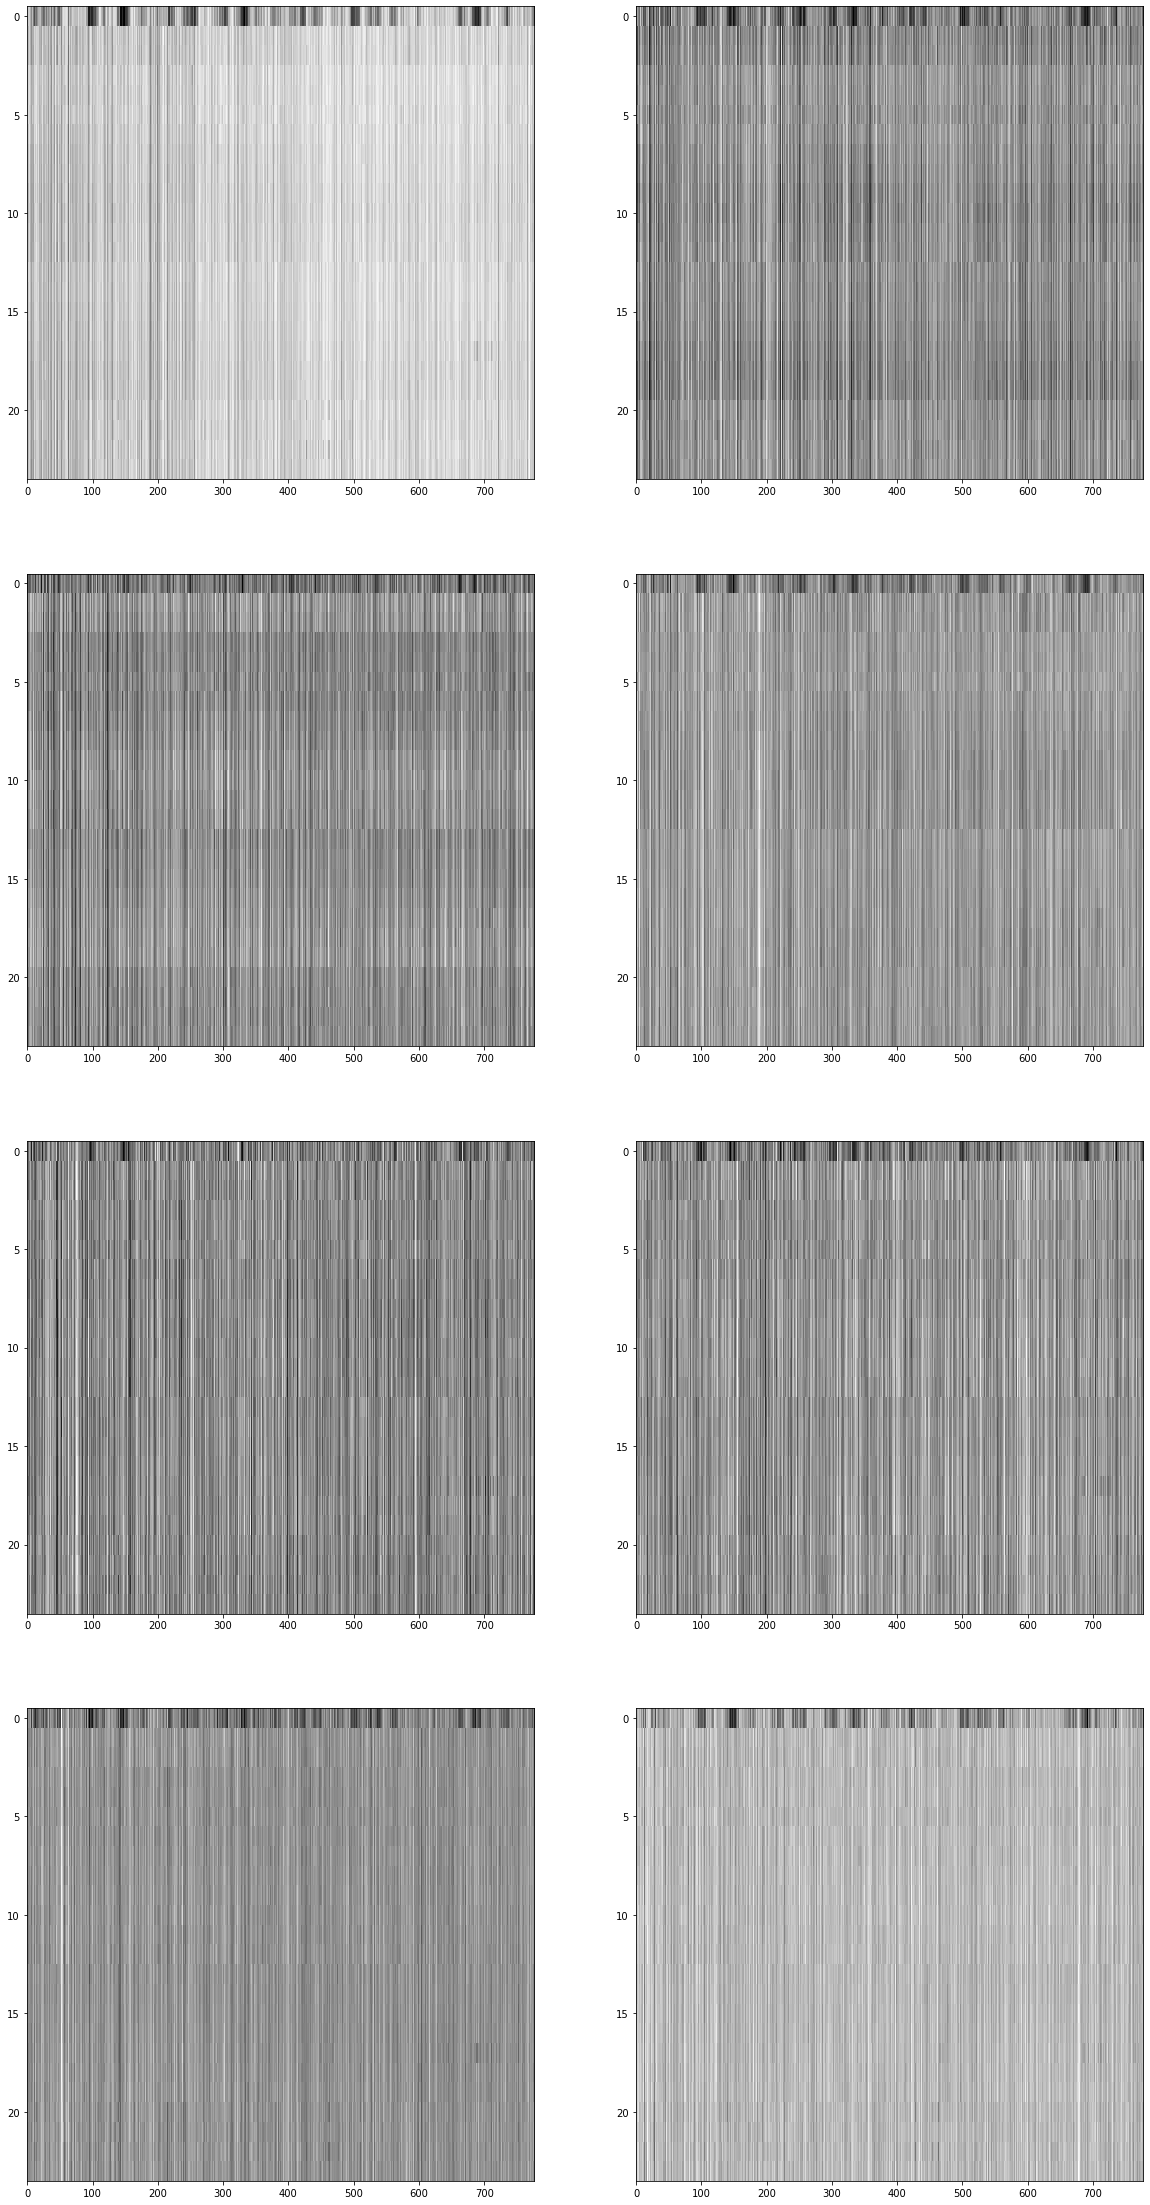

In [43]:
sessions = [
    'NPR-076.c09',
    #'NPR064.c09',
    #'NPR065e.03'
]

channelData = {
    a: [
        pca_model.transform(v[ : , epoch_idxs].copy()) 
        for _, v in sorted(dataDict[a].items(), key = lambda x: x[0])
    ]
    for a in sessions
}

for a in sessions:
    print(a)
    for chan in sorted(dataDict[a].keys()):
        print(chan)
    print()
    

plt.figure(figsize = (20, 40))
for idx in range(n_components):
    plt.subplot(4, 2, idx + 1)
    plt.imshow(
        np.array(channelData['NPR-076.c09'])[ : , : , idx],
        cmap = 'gist_yarg',
        aspect = 'auto'
    )
plt.show()

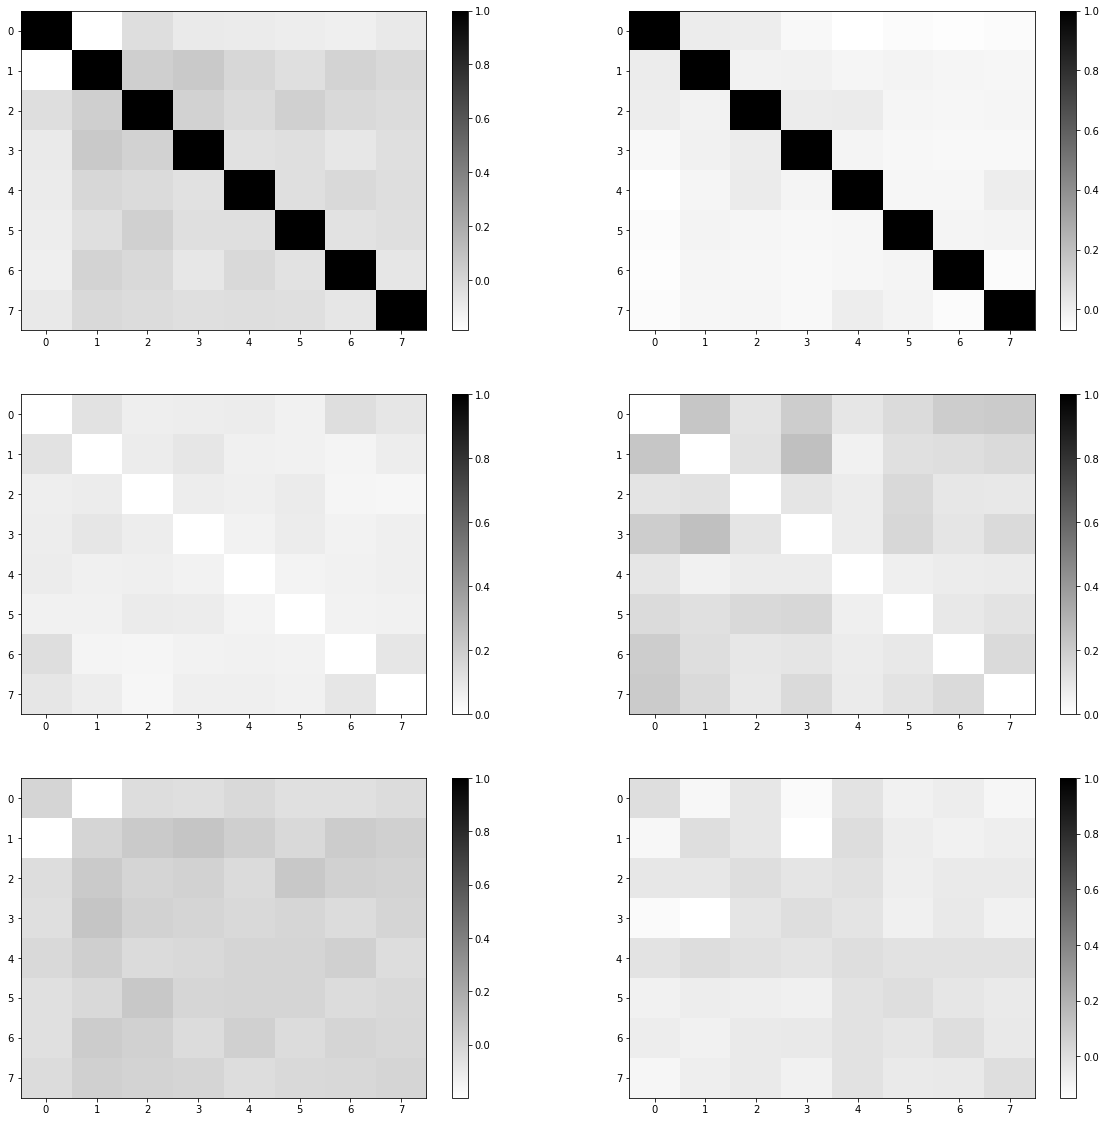

In [144]:
# Goal:     Predict STR or GP channel
# Purpose:  Shits and giggles
# Approach: Cross-correlation matrices are very distinctly different.
#           Abuse.
#
#   This did not work out.
#   Crosscorrelations are not as distincly different when 
#     only considering a single channel at a time.
#
#

from random import choice

ALL = []

master_str = np.corrcoef(pcs_str.transpose())
master_gp  = np.corrcoef(pcs_gp .transpose())

master_str = master_str / master_str.sum()
master_gp  = master_gp  / master_gp .sum()

for session, channels in dataDict.items():
    for name, data in channels.items():
        if not (session, name) in BANNED:
            ALL.append((name, data))

def getRandomChannel():
    raw = choice(ALL)
    name = raw[0]
    data = raw[1][ : , epoch_idxs]
    data = pca_model.transform(data.copy())
    return (name, np.corrcoef(data.transpose()))
    
def testChannel(nameData):
    name, data = nameData
#     out = f"{name}:\t{np.abs(data).sum()}"
#     data = data / data.sum()
#     _str = (master_str - data).sum()
#     _gp  = (master_gp  - data).sum()
#     out += f"\t{_gp}\t{_str}"
#     return out
    return (name, data)
    
tests = [testChannel(getRandomChannel()) for _ in range(100)]
strs = np.array([test for name, test in tests if "str_lfp" in name])
gps  = np.array([test for name, test in tests if  "gp_lfp" in name])

plt.figure(figsize = (20, 20))
plt.subplot(3, 2, 1)
plt.imshow(
    strs.mean(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto',
    vmax = 1
)
plt.colorbar()
plt.subplot(3, 2, 2)
plt.imshow(
    gps.mean(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto',
    vmax = 1
)
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(
    strs.std(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto',
    vmax = 1
)
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(
    gps.std(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto',
    vmax = 1
)
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(
    strs.mean(axis = 0) - gps.mean(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto',
    vmax = 1
)
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(
    strs.std(axis = 0) - gps.std(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto',
    vmax = 1
)
plt.colorbar()
plt.show()

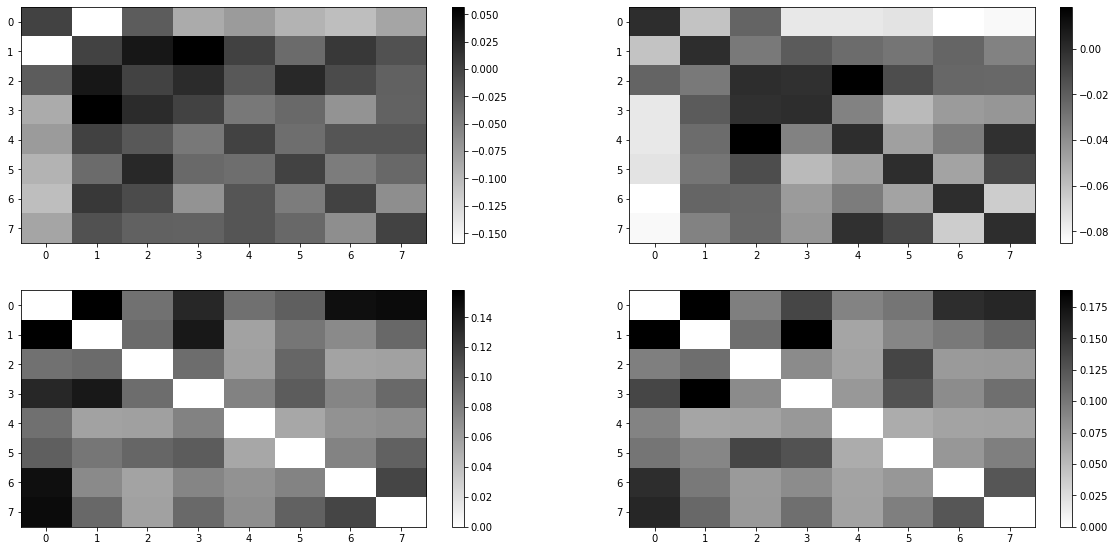

In [170]:
corr_str = np.array([
    np.corrcoef(
        pca_model.transform(
            data[ : , epoch_idxs].copy()
        ).transpose()
    )
    for name, data in ALL
    if "str_lfp" in name
])
corr_gp = np.array([
    np.corrcoef(
        pca_model.transform(
            data[ : , epoch_idxs].copy()
        ).transpose()
    )
    for name, data in ALL
    if "gp_lfp" in name
])

for i in range(n_components):
    corr_str[ : , i, i] = 0
    corr_gp[ : , i, i] = 0

plt.figure(figsize = (20, 20))

plt.subplot(4, 2, 1)
plt.imshow(
    corr_str.mean(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto'
)
plt.colorbar()

plt.subplot(4, 2, 2)
plt.imshow(
    corr_gp.mean(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto'
)
plt.colorbar()

plt.subplot(4, 2, 3)
plt.imshow(
    corr_str.std(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto'
)
plt.colorbar()

plt.subplot(4, 2, 4)
plt.imshow(
    corr_gp.std(axis = 0),
    cmap = 'gist_yarg',
    aspect = 'auto'
)
plt.colorbar()

plt.show()